オリジナルの作成: 2016/05/03

<html>
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>SageでTheanoの手書き数字認識（MNIST）を試す</h1>
	<h2>参考サイト</h2>
	<p>	
		ここでは、
		 <a href="http://aidiary.hatenablog.com/">人工知能に関する断創録</a>
		 のTheanoに関連する記事をSageのノートブックで実装し、Thenoの修得を試みます。	
	</p>
	<p>
		今回は、TheanoのTutorialからMNISTの手書き数字認識を以下のページを参考にSageのノートブックで試してみます。
		<ul>
			<li>
				<a href="http://aidiary.hatenablog.com/entry/20150526/1432648414">Theanoによるロジスティック回帰の実装</a>
			</li>
		</ul>		
	</p>
</html>

<html>
	<h2>処理系をSageからPythonに変更</h2>
	<p>
		SageでTheanoのtutorialのMNISTを実行すると、以下のy_predがベクトルではなくスカラーになり、うまく処理できません。
		<pre>
	self.y_pred = T.argmax(self.p_y_given_x, axis=1)			
		</pre>		
	</p>
	<p>
		そこで、ノートブックの処理系をSageからPythonに切り替えます。上部の左から4つめのプルダウンメニューから
		「python」を選択してください。
	</p>
	<p>
		<img src="images/theano_setup.png"/>
	</p>
</html>

<html>
	<h2>必要なライブラリをインポート</h2>
	<p>
		今回は、ちょっと多くのライブラリを使用します。
	</p>
</html>

In [1]:
# 必要なライブラリのインポート
import six.moves.cPickle as pickle
import gzip
import os
import sys
import timeit
import urllib

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import theano
import theano.tensor as T

<html>
	<h2>データのセットアップ</h2>
	<h3>データのダウンロード</h3>
	<p>
		TheanoのTutorialで使用しているMNISTは手書き数字の画像データセットは、
		cPickleモジュールでロードできる形式に圧縮したmnist.pkl.gzが以下のサイトから
		ダウンロードできます。
		<ul>
			<li>http://deeplearning.net/data/mnist/mnist.pkl.gz</li>
		</ul>
	</p>
	<p>
		MNISTのデータには、70000の手書き数字データが収録されおり、それを以下の様に分割して使用します。
		<ul>
			<li>50000の訓練セット</li>
			<li>10000のバリデーションセット</li>
			<li>10000のテストセット</li>
		</ul>
		
		各サンプル画像は、28x28=784個の配列に格納され、データの値は0.0から1.0に正規化されています。
	</p>
	<p>
		TensorFlowのMNIST for ML BeginnersのMNISTデータの説明が分かりやすいので、引用します。
	</p>
	<p>
		<img width="50%" height="50%" src="https://www.tensorflow.org/versions/r0.7/images/MNIST-Matrix.png"/>
	</p>
</html>

In [2]:
# データのダウンロード(最初１回だけ実行)
# urllib.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "data/mnist.pkl.gz")
# Sageサーバではメモリ不足のため、1/10のmini_mnist_pkl.gzを作成してこれで計算することにした

In [3]:
# 以下の手順でmini_mnist.pk.gzを作成（コメントを外す）
#mini_train_set = (train_set[0][0:5000], train_set[1][0:5000])
#mini_valid_set = (valid_set[0][0:500], valid_set[1][0:500])
#mini_test_set = (test_set[0][0:500], test_set[1][0:500])
#f = gzip.open(DATA+"mini_mnist.pkl.gz", 'wb')
#pickle.dump((mini_train_set, mini_valid_set, mini_test_set), f)
#f.close()

<html>
	<h3>1/10のサブセットを作成</h3>
	<p>
		Sageサーバのメモリは1Gと少ないため、MNISTのデータをそのまま使用するとメモリ不足になります。
		そこで、1/10のサイズのサブセットデータmini_mnist.pkl.gzを作成し、これを使用して数字を認識することにします。
	</p>
</html>

In [4]:
# データセットをロードする
#f = gzip.open("data/mnist.pkl.gz", 'rb')
f = gzip.open("data/mini_mnist.pkl.gz", 'rb')
train_set, valid_set, test_set = pickle.load(f)
f.close()

In [5]:
# データは、(画像データとラベル）のタプルで、画像データは5000サンプルで、各画像データは28x28=784、ラベルはint64の型
print len(train_set), train_set[0].shape, train_set[1].shape, type(train_set[1][0])

2 (5000, 784) (5000,) <type 'numpy.int64'>


<html>
	<h3>サンプルデータについて</h3>
	<p>
		どのような画像データが入っているのか、訓練用データ（train_set）の最初の100個を表示してみましょう。
	</p>
</html>

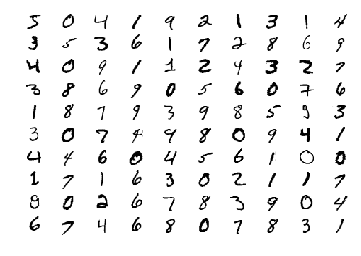

In [6]:
# 訓練用データを100個表示
for index in range(100):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(train_set[0][index].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')

<html>
	<h3>データをTheanoの共有変数に格納</h3>
	<p>
		Theanoの共有変数を使用すると、GPUのメモリ領域に保存され、学習時（update）に高速に読み書きできます。
		共有変数の値を取り出すときに、get_value()を使用するのは、GPUにセットされたデータをCPUのメモリにコピー
		するためと考えられます。
	</p>
	<p>
		また、GPUで使用するデータは必ずfloat型で格納しなければなりません。
		そのため、ラベルshared_yは、T.cast(shared_y, 'int32')でキャストして返しています。
	</p>
	<p>
		これでdatasets変数に訓練用、検証用、テスト用のデータがセットされました。
	</p>
</html>

In [7]:
# データセットをGPUの共有変数に格納
def shared_dataset(data_xy, borrow=True):
    data_x, data_y = data_xy

    # 共有変数には必ずfloat型で格納
    shared_x = theano.shared(
        np.asarray(data_x, dtype=theano.config.floatX), borrow=borrow)
    shared_y = theano.shared(
        np.asarray(data_y, dtype=theano.config.floatX), borrow=borrow)

    # ラベルはint型なのでキャストして返す
    return shared_x, T.cast(shared_y, 'int32')

test_set_x, test_set_y = shared_dataset(test_set)
valid_set_x, valid_set_y = shared_dataset(valid_set)
train_set_x, train_set_y = shared_dataset(train_set)

datasets = [(train_set_x, train_set_y),
        (valid_set_x, valid_set_y),
        (test_set_x, test_set_y)]

<html>
	<h2>多クラス分類</h2>
	<p>
		ニューラルネットの入力$x_i$と出力$u_i$の関係は、重み$W_i$とバイアス$b_i$を使って以下の関係になります。
$$
	u_i = \sum_j W_{i,j} x_j + b_i
$$		
	</p>
	<p>
		これを分かりやすく説明した図を再度、TensorFlowのMNIST for ML Beginnersから引用します。
	</p>
	<p>
		<img width="50%" height="50%" src="https://www.tensorflow.org/versions/r0.7/images/softmax-regression-scalargraph.png"/>
	</p>
	<p>
		この重みWとバイアスbをTheanoの共有変数でセットしているのが、以下の箇所です。
		<pre>
        # 重み行列を初期化
        self.W = theano.shared(value=np.zeros((n_in, n_out),
                                              dtype=theano.config.floatX),
                               name='W',
                               borrow=True)

        # バイアスベクトルを初期化
        self.b = theano.shared(value=np.zeros((n_out,),
                                              dtype=theano.config.floatX),
                               name='b',
                               borrow=True)			
		</pre>		
	</p>
</html>

<html>
	<h3>ソフトマック関数</h3>
	<p>
		多クラス分類の活性化関数として使用されるのが、ソフトマック関数（Softmax）で、出力層のクラスiに分類される確率は、以下の様に表されます。
$$
	y_i = \frac{exp(u_i)}{\sum_j exp(u_j)}
$$		
	</p>
	<p>
		<img width="50%" height="50%" src="https://www.tensorflow.org/versions/r0.7/images/softmax-regression-vectorequation.png"/>
	</p>
	<p>
		この部分をTheanoのシンボルで表現している箇所が以下の部分です。
		<pre>
        # 各サンプルが各クラスに分類される確率を計算するシンボル
        # 全データを行列化してまとめて計算している
        # 出力は(n_samples, n_out)の行列
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)			
		</pre>
	</p>
	<p>
		人工知能に関する断創録の貴重なコメントがあります。
		<ul>
			<li>T.dot(self.W, input)+ self.bは、サンプルxを1つだけ与えたときの確率を計算している</li>
			<li>T.dot(input, self.W)+ self.bは、複数のサンプル（ミニバッチ単位）を行列化してinputに与え、それらのサンプルの確率をまとめて計算している</li>
		</ul>
	</p>
	<p>
		確率が求まったら最終的に一番高い確率が得られるクラスをy_predにセットします。
$$
		y_{pred} = argmax(y)
$$		
		TheanoではT.argmax()にaxis=1を指定することでp_y_given_xの各行（サンプルに相当）において一番確率が高いインデックス（クラスに相当）がまとめて取得できるそうです。
		<pre>
        # 確率が最大のクラスのインデックスを計算
        # 出力は(n_samples,)のベクトル
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)			
		</pre>
	</p>	
</html>

<html>
	<h3>コスト関数</h3>
	<p>
		分類されたクラスkだけ１で、他は0のベクトルを$d_n$とすると、事後分布は、以下の様になります。
$$
	p(d | x) = \prod_{k=1}^K p(C_k | x)^{d_k}
$$
		訓練データ${ (x_n, d_n)}(n=1,...,N)$に対するwの尤度は、以下の様になります。
$$
	L(W) = \prod_{n=1}^N p(d_n | x_n; W) = \prod_{n=1}^N \prod_{k=1}^K p(c_k|x_n)^{d_{nk}} = \prod_{n=1}^N \prod_{k=1}^K (y_k(x; W))^{d_{nk}}
$$		
	</p>
	<p>
		負の対数尤度を誤差関数とすると
$$
	E(W) =  - \sum_{n=1}^N \sum_{k=1}^K d_{nk} log y_k(x_n; W)
$$		
	</p>
	<p>
		人工知能に関する断創録では、Sumの代わりに平均meanを使っていることに注意！
		<pre>
        # 式通りに計算するとsumだがmeanの方がよい
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])			
		</pre>
	</p>
</html>

In [8]:
class LogisticRegression(object):

    def __init__(self, input, n_in, n_out):
        """ロジスティック回帰モデルの初期化
        input: ミニバッチ単位のデータ行列（n_samples, n_in）
        n_in : 入力の次元数
        n_out: 出力の次元数
        """
        # 重み行列を初期化
        self.W = theano.shared(value=np.zeros((n_in, n_out),
                                              dtype=theano.config.floatX),
                               name='W',
                               borrow=True)

        # バイアスベクトルを初期化
        self.b = theano.shared(value=np.zeros((n_out,),
                                              dtype=theano.config.floatX),
                               name='b',
                               borrow=True)

        # 各サンプルが各クラスに分類される確率を計算するシンボル
        # 全データを行列化してまとめて計算している
        # 出力は(n_samples, n_out)の行列
        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

        # 確率が最大のクラスのインデックスを計算
        # 出力は(n_samples,)のベクトル
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)

        # ロジスティック回帰モデルのパラメータ
        self.params = [self.W, self.b]

        # モデルの入力値を保持
        self.input = input
        
    def negative_log_likelihood(self, y):
        """誤差関数である負の対数尤度を計算するシンボルを返す
        yにはinputに対応する正解クラスを渡す
        """
        # 式通りに計算するとsumだがmeanの方がよい
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):
        """分類の誤差率を計算するシンボルを返す
        yにはinputに対応する正解クラスを渡す"""
        if y.ndim != self.y_pred.ndim:
            raise TypeError('y should have the same shape as self.y_pred',
                            ('y', y.type, 'y_pred', self.y_pred.type))

        if y.dtype.startswith('int'):
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()

<html>
	<h2>モデルの訓練</h2>
	<p>
		モデルの訓練には、ミニバッチ確率的勾配降下法（MSGD）を使用しています。
		確率的勾配降下法（SGD）はただ1つのサンプルで1回だけパラメータを更新するのに対し、
		少数のサンプルをひとまとめにしてその単位で重みを更新します。
		このひとまとめにしたサンプル集合をミニバッチ（minbatch）と呼びます。
	</p>
	<p>
		何番目のミニバッチを使用するかを示すのがシンボルindexです。
		コードのfunction()のgivensで定義されている部分がミニバッチの設定箇所です。
		<pre>
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }			
		</pre>
	</p>
	<p>
		確率的勾配降下法で使用するコスト関数とその微分は、負の対数尤度を計算する
		negative_log_likelihood関数とT.gradの箇所で計算しています。
		<pre>
    # 誤差（コスト）を計算 => 最小化したい
    cost = classifier.negative_log_likelihood(y)
    # コスト関数のtheta = (W,b)の微分を計算
    g_W = T.grad(cost=cost, wrt=classifier.W)
    g_b = T.grad(cost=cost, wrt=classifier.b)			
		</pre>
	</p>
	<p>
		パラメータの更新式は、Wとbの2個をタプルとして指定します。
		<pre>
    # パラメータ更新式
    updates = [(classifier.W, classifier.W - learning_rate * g_W),
               (classifier.b,  classifier.b - learning_rate * g_b)]			
		</pre>
	</p>
	<p>
		関数の定義は以下の通りです。
		<ul>
			<li>inputs：何番目のミニバッチかを示すインデックスをindexで与え</li>
			<li>outputs：負の対数尤度を計算するcostを渡す</li>
			<li>updates：update式を渡す</li>
			<li>givens：関数を実行する際にシンボルを置き替えるオプションで、ここではじめてxとyに値をセットしています</li>
		</ul>
	</p>
</html>

<html>
	<h3>モデルの評価</h3>
	<p>
		モデルの当てはまりの良さをエラー率で評価しています。LogisticRegressionのerrors関数で計算します。
		<pre>
    def errors(self, y):
        """分類の誤差率を計算するシンボルを返す
        yにはinputに対応する正解クラスを渡す"""
        return T.mean(T.neq(self.y_pred, y))
		</pre>
		T.neq(self.y_pred, y)で予測クラスと正解クラスが異なる要素の数を求め、
		その平均を取ることでエラー率を計算しています。
	</p>
</html>

<html>
	<h3>Early-Stoppingによる収束判定</h3>
	<p>
		検証用データvalid_setのエラー率と訓練用データtrain_setのエラー率から適合（overfitting）を防ぐために、
		検証用データのエラー率が増加した時点で学習を打ち切る早期終了（Early-Stopping）というテクニックを使用します。
	</p>
	<p>
		人工知能に関する断創録に解説されているEarly-Stoppingの説明を引用します。
		<ul>
			<li>モデルの訓練は訓練データのミニバッチ単位で行う。</li>
			<li>エポック epoch は訓練データのミニバッチを使い切ったら+1される。
				訓練データを一通り使いきっても収束していなければまた最初のミニバッチに戻って同じデータを繰り返し使ってパラメータ更新する。</li>
			<li>最初の while ループは、最大n_epochs 回エポックを繰り返されたら更新を終えることを意味する。
				これによりたとえ収束しなくてもプログラムはいつかは終わることが保証される。</li>
			<li>iterはこれまで訓練に使用したミニバッチの数が入る。つまり、パラメータ更新回数を意味する。</li>
			<li>パラメータ更新回数がpatienceを超えたらもうこれ以上更新してもモデルは改善しないと判断されてループを抜ける。
				逆に言うと、patienceの値が上がるとまだまだパラメータ更新によるモデル改善の余地があると判断されてことになる。</li>
			<li>patienceを上げるかどうかの判断はバリデーションセットを用いて決められる。</li>
			<li>validation_frequency回更新されるたびにモデルの検証が行われる。</li>
			<li>バリデーションセットを用いて平均エラー率が計算され、
				この平均エラー率がこれまでの最良の平均エラー率より十分な程度下がっていればまだまだモデル改善の余地ありと判断してpatienceを引き上げる。
				十分かどうかはimprovement_thresholdで調整できる。</li>
			<li>この検証の際にテストセットを用いたモデルのエラー率の評価も合わせて行う。</li>
		</ul>
	</p>
</html>

In [9]:
def sgd_optimization_mnist(learning_rate=0.13, n_epochs=100,
                           dataset='mnist.pkl.gz',
                           batch_size=60):
    # 先にセットした学習データを利用
    # datasets = load_data(dataset)

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # ミニバッチの数
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
    n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

    print('... building the model')

    # シンボルの割り当て
    # ミニバッチのインデックスを表すシンボル    
    index = T.lscalar()  # index to a [mini]batch
    
    # ミニバッチの学習データとラベルを表すシンボル
    x = T.matrix('x')  # data, presented as rasterized images
    y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

    # MNISTの手書き数字を分類する多クラス分類モデル
    # 入力は28ピクセルx28ピクセルの画像、出力は0から9のラベル
    # 入力はシンボルxを割り当てておいてあとで具体的なデータに置換する
    classifier = LogisticRegression(input=x, n_in=28 * 28, n_out=10)

    # 誤差（コスト）を計算 => 最小化したい
    cost = classifier.negative_log_likelihood(y)

    # index番目のテスト用ミニバッチを入力してエラー率を返す関数を定義
    test_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={    # ここで初めてシンボル x, y を具体的な値で置き換える
            x: test_set_x[index * batch_size: (index + 1) * batch_size],
            y: test_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    
    # index番目のバリデーション用ミニバッチを入力してエラー率を返す関数を定義
    validate_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    # コスト関数のtheta = (W,b)の微分を計算
    g_W = T.grad(cost=cost, wrt=classifier.W)
    g_b = T.grad(cost=cost, wrt=classifier.b)

    # パラメータ更新式
    updates = [(classifier.W, classifier.W - learning_rate * g_W),
                        (classifier.b,  classifier.b - learning_rate * g_b)]

    # index番目の訓練バッチを入力し、パラメータを更新する関数を定義
    # 戻り値としてコストが返される
    # この関数の呼び出し時にindexに具体的な値が初めて渡される
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    print('... training the model')
    
    # eary-stoppingのパラメータ
    # patience = 5000  
    patience = 500
    patience_increase = 2 
    improvement_threshold = 0.995 
    validation_frequency = min(n_train_batches, patience // 2)

    best_validation_loss = np.inf
    test_score = 0.
    start_time = timeit.default_timer()

    done_looping = False
    epoch = 0
    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
            # minibatch_index番目の訓練データのミニバッチを用いてパラメータ更新
            minibatch_avg_cost = train_model(minibatch_index)
            
            # validation_frequency回の更新ごとにバリデーションセットによるモデル検証が入る
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                # バリデーションセットの平均エラー率を計算
                validation_losses = [validate_model(i)
                                     for i in range(n_valid_batches)]
                this_validation_loss = np.mean(validation_losses)

                print(
                    'epoch %i, minibatch %i/%i, validation error %f %%' %
                    (
                        epoch,
                        minibatch_index + 1,
                        n_train_batches,
                        this_validation_loss * 100.
                    )
                )

                # エラー率が十分改善したならまだモデル改善の余地があるため
                # patienceを上げてより多くループを回せるようにする
                if this_validation_loss < best_validation_loss:
                    #improve patience if loss improvement is good enough
                    if this_validation_loss < best_validation_loss *  \
                       improvement_threshold:
                        patience = max(patience, iter * patience_increase)

                    best_validation_loss = this_validation_loss
                    
                    # テストセットを用いたエラー率も求めておく
                    test_losses = [test_model(i)
                                   for i in range(n_test_batches)]
                    test_score = np.mean(test_losses)

                    print(
                        (
                            '     epoch %i, minibatch %i/%i, test error of'
                            ' best model %f %%'
                        ) %
                        (
                            epoch,
                            minibatch_index + 1,
                            n_train_batches,
                            test_score * 100.
                        )
                    )

                    # save the best model
                    with open('data/best_model.pkl', 'wb') as f:
                        pickle.dump(classifier, f)
                        
            # patienceを超えたらループを終了
            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print(
        (
            'Optimization complete with best validation score of %f %%,'
            'with test performance %f %%'
        )
        % (best_validation_loss * 100., test_score * 100.)
    )
    print('The code run for %d epochs, with %f epochs/sec' % (
        epoch, 1. * epoch / (end_time - start_time)))
    print('Ran for %.1fs' % ((end_time - start_time)))

In [10]:
sgd_optimization_mnist()

... building the model
... training the model
epoch 1, minibatch 83/83, validation error 16.458333 %
     epoch 1, minibatch 83/83, test error of best model 15.833333 %
epoch 2, minibatch 83/83, validation error 14.375000 %
     epoch 2, minibatch 83/83, test error of best model 12.916667 %
epoch 3, minibatch 83/83, validation error 13.333333 %
     epoch 3, minibatch 83/83, test error of best model 11.666667 %
epoch 4, minibatch 83/83, validation error 13.541667 %
epoch 5, minibatch 83/83, validation error 13.750000 %
epoch 6, minibatch 83/83, validation error 13.125000 %
     epoch 6, minibatch 83/83, test error of best model 10.833333 %
epoch 7, minibatch 83/83, validation error 12.916667 %
     epoch 7, minibatch 83/83, test error of best model 10.208333 %
epoch 8, minibatch 83/83, validation error 13.125000 %
epoch 9, minibatch 83/83, validation error 13.125000 %
epoch 10, minibatch 83/83, validation error 12.916667 %
epoch 11, minibatch 83/83, validation error 12.916667 %
epoch 1

<html>
	<h2>学習結果を使った予測</h2>
	<p>
		テスト用データtest_setの最初の25個に対して認識を行い、予測結果と画像を合わせて表示してみます。
	</p>
	<p>
		1/10の学習データでもそこそこ良い結果が得られています。
	</p>
</html>

In [11]:
# 学習結果をテスト用データで確かめる
classifier = pickle.load(open('data/best_model.pkl'))
test_set_x, test_set_y = datasets[2]
test_set_x = test_set_x.get_value()

# compile a predictor function
predict_model = theano.function(
        inputs=[classifier.input],
        outputs=classifier.p_y_given_x
   )
    
predicted_values = predict_model(test_set_x[:25])
print("Predicted values for the first 10 examples in test set:")
print(["(%d, %.3f)" % (np.argmax(value), max(value)) for  value in predicted_values])

Predicted values for the first 10 examples in test set:
['(7, 0.988)', '(2, 0.733)', '(1, 0.951)', '(0, 0.995)', '(4, 0.936)', '(1, 0.979)', '(4, 0.957)', '(9, 0.912)', '(6, 0.912)', '(9, 0.844)', '(0, 0.904)', '(6, 0.668)', '(9, 0.917)', '(0, 0.983)', '(1, 0.991)', '(5, 0.832)', '(9, 0.790)', '(7, 0.986)', '(3, 0.659)', '(4, 0.979)', '(9, 0.775)', '(6, 0.952)', '(6, 0.801)', '(5, 0.955)', '(4, 0.862)']


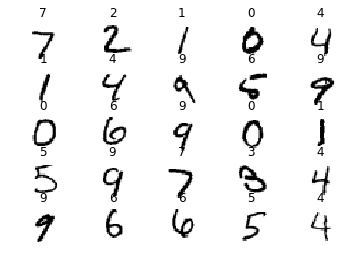

In [12]:
# 画像と認識結果を一緒に表示
for index in range(25):
    plt.subplot(5, 5, index + 1)
    plt.axis('off')
    plt.imshow(test_set_x[index].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('%i' % predicted_values[index].argmax())

<html>
	<h3>重みWのパターン</h3>
	<p>
		最後に各クラスを識別した重みWがどのように形に求まったのかみてみましょう。
	</p>
	<p>
		赤い部分で正で、葵部分が負の値です。各数字の特徴的な部分に赤の部分が見られることが分かります。
	</p>
</html>

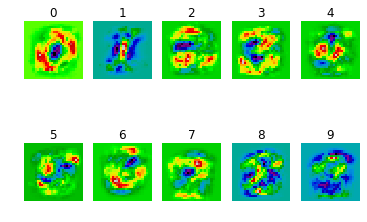

In [13]:
# Wにどのような値がセットされたか表示する
w = classifier.W.get_value()
for index in range(10):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(w[:, index].reshape(28, 28), cmap=plt.cm. spectral, interpolation='nearest')
    plt.title('%i' % index)